# Prepare Antwerp LoRaWAN link data

This notebook describes how the raw Antwerp LoRaWAN data is processed into a link-level geojson dataset.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterstats as rs
import osmnx as ox
from shapely import Point
from shapely.geometry import box, LineString
import rioxarray as rxr

**Note**: Not all data is included in the github repo.
- This notebook contains links for the raw LoRaWAN `.json` data.
- Ask Sander `sea78@cornell.edu` about the rasters and other files - they should be made public soon.

## Process uplink data

**Note:** The code uses the Coordinate Reference System (CRS) of the DEM raster as a reference. If you use this code for data collected in a location other than Antwerp, you must make sure that the corresponding DEM raster uses an appropriate CRS.

The recommended CRS is [Universal Transverse Mercator (UTM)](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system), for the area you are working in.

To change the CRS of a raster, use, e.g., ``rioxarray.reproject`` [(docs)](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray.raster_array.RasterArray.reproject).

In [2]:
# Load Digital Elevation Model raster
dem_path = '/Volumes/Transcend/lora/data/antwerp-gis/dtm-1m-clipped.tif' # '/proppy_data/antwerp_dtm_1m.tif'
dem = rxr.open_rasterio(dem_path, masked=True).squeeze()
print(f"Loaded raster of shape: {dem.shape}.")
print(f"The DEM raster has CRS: {dem.rio.crs}.")

# Make a dataframe of bounds
bbox_dem = box(*dem.rio.bounds())
dem_bounds = gpd.GeoDataFrame(geometry=[bbox_dem])
dem_bounds = dem_bounds.set_crs(dem.rio.crs)

Loaded raster of shape: (10687, 12728).
The DEM raster has CRS: EPSG:31370.


In [3]:
# Load road network graph
G = ox.graph_from_place('Antwerp, Belgium', network_type='all')

nodes, roads = ox.graph_to_gdfs(G)

roads = roads.to_crs(dem.rio.crs)

roads = roads[['geometry', 'osmid']]

print(f"Loadded {len(roads):,} road segments.")

Loadded 68,685 road segments.


Next, you'll need the actual LoRaWAN data. If you did not download it yet, you can do so by clicking [here](https://zenodo.org/record/3904158/files/lorawan_antwerp_gateway_locations.json.txt?download=1). Put the file `lorawan_antwerp_2019_dataset.json.text` in a `proppy/data/antwerp` folder. You may need to make one.


**NOTE**:
We could (and should) write a `load_antwerp_data()`-function that does this for you.


The next cell does cleaning and processing. The code should be relatively self-explanatory.

In [4]:
# Load json file of uplinks
path = '../../data/antwerp/lorawan_antwerp_2019_dataset.json.txt' # this is the raw data

# Clean data and rename columns / axis
uplinks = (pd.read_json(path)
    .drop(columns=['payload', 'counter', 'adr', 'airtime', 'dev_eui'])
    .rename(columns={'longitude':'lon_tx',
                     'latitude': 'lat_tx',
                     'dev_addr': 'dev_id'}
            )
    .rename_axis('uplink_id')
    .reset_index()
)

print(f"Loaded uplink data for \t\t{uplinks.shape[0]:,} observations.")

# Make points for uplink locations
points_tx = [Point(xy) for xy in zip(uplinks['lon_tx'], uplinks['lat_tx'])]

uplinks = (gpd.GeoDataFrame(geometry=points_tx, data=uplinks)
           .set_crs("EPSG:4326")
           .to_crs(dem.rio.crs)
)

# Discard points not within DEM bounds
uplinks = uplinks[uplinks.within(bbox_dem)]

# Filter on small HDOP
uplinks = uplinks.query('hdop <= 1.0')

# Keep observations from devices with at least 1000 obs
devices = (uplinks['dev_id'].value_counts()[lambda x: x > 1000]
           .index
           .tolist()
)

uplinks = uplinks.query('dev_id.isin(@devices)')

# Filter on distance to road and previous observation
uplinks = (gpd.sjoin_nearest(uplinks, roads, how='left',
                             max_distance = 500,
                             distance_col='dist_to_road')
                             
            .groupby('uplink_id').first()
            .drop(columns=['index_right0', 'index_right1', 'index_right2'])
          )

uplinks['geometry_prev'] = uplinks.groupby('dev_id')['geometry'].shift(1)

uplinks['dist_from_prev'] = uplinks['geometry'].distance(uplinks['geometry_prev'])

# Keep only uplinks that are near a road and within (10, 1000) m of previous obs
filter = "dist_to_road < 10 & dist_from_prev > 10  & dist_from_prev < 1000"
uplinks = (uplinks
           .query(filter)
           .drop(columns=['osmid', 'dist_to_road', 'geometry_prev', 'dist_from_prev'])
           .reset_index(drop=True)
)

print(f"Retained uplink data for \t{uplinks.shape[0]:,} observations.")

Loaded uplink data for 		130,430 observations.
Retained uplink data for 	32,070 observations.


So far, we only have `(x, y)`-coordinates for each transmission origin. We fetch `z`-coordinates, or elevation levels, next.

In [5]:
# Query uplink location elevation (m)
point_values = rs.zonal_stats(uplinks.geometry,
                              dem.values,
                              nodata=np.nan,
                              affine=dem.rio.transform(),
                              geojson_out=True,
                              copy_properties=True,
                              stats="min")

# make gdf from query and save attribute
point_values = gpd.GeoDataFrame.from_features(point_values)

uplinks['ele_tx'] = point_values['min'].values

uplinks['ele_tx'] += 1.5 # add dist from ground level 

## Process gateway data

Next, we process the gateway data.

Elevation data of gateways is not provided in the dataset. Instead, we can query the elveation at each GW location. To do so, we want not the ground level, but the full surface including buildings and structures. For this, a digital surface model (`dsm`) is idea.

In [6]:
# Load digital surface model (DSM)
dsm_path = '/Volumes/Transcend/lora/data/antwerp-gis/dsm-1m-clipped.tif' # `proppy_data/antwerp_dsm_1m.tif`
dsm = rxr.open_rasterio(dsm_path, masked=True).squeeze()

In [7]:
# load data
gw_path = '/Volumes/Transcend/lora/data/traffic/lorawan_antwerp_gateway_locations.json'
gateways = pd.read_json(gw_path).transpose()

print(f"Loaded data on {len(gateways):,} gateways.")

# Make points for uplink locations
points_gw = [Point(xy) for xy in zip(gateways['longitude'], gateways['latitude'])]

gateways = (gpd.GeoDataFrame(geometry=points_gw, data=gateways)
            .set_crs("EPSG:4326")
            .to_crs(dem.rio.crs)
)

# Keep gateways inside bounds, discard others
gateways = gateways[gateways.within(bbox_dem)]

# Query gateway location elevation (m)
point_values = rs.zonal_stats(gateways.geometry,
                              dsm.values,
                              nodata=np.nan,
                              affine=dsm.rio.transform(),
                              geojson_out=True,
                              copy_properties=True,
                              stats="max")

# make gdf from query and save attribute
point_values = gpd.GeoDataFrame.from_features(point_values)

gateways['ele_gw'] = point_values['max'].values

print(f"Retained data on {len(gateways):,} gateways.")

Loaded data on 249 gateways.
Retained data on 33 gateways.


We're now ready to view our gateways and transmission origins.

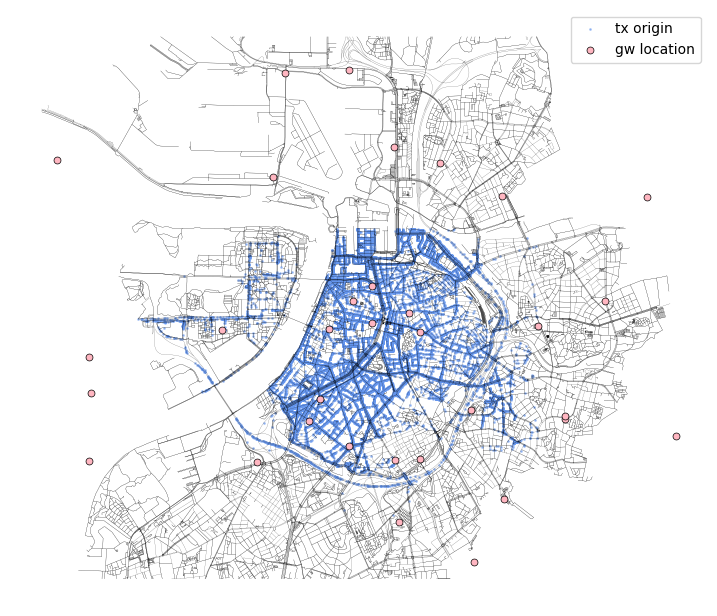

In [10]:
# Plot the loactions
fig, ax = plt.subplots(figsize=(9,9))
roads.clip(bbox_dem).plot(color='k', linewidth=0.1, ax=ax)
uplinks.plot(ax=ax, markersize=1, alpha=0.5, color='cornflowerblue', label='tx origin')
gateways.plot(ax=ax, markersize=25, color='lightpink', ec='k', lw=.5, zorder=10, label='gw location')
plt.axis("off")
plt.legend()
plt.show()

# Expanding to link-level data

So far we have `uplinks` and `gateways`. For studying wireless propagation, we'd like `links`. Links are `(uplink, gateway)`-pairs.

In [11]:
# Expand json column to link-level data

links_good = (uplinks.reset_index()
              .rename(columns={'index':'uplink_id'})
              .explode('gateways').reset_index(drop=True)
)

json_cols = (
    pd.json_normalize(links_good['gateways'])
    .drop(columns=['rx_time.ts_type'])
    .rename(columns={'rx_time.time':'time', 'id':'gw_id'})
)

links_good = (
    pd.concat((links_good, json_cols), axis=1)
    .drop(columns=['gateways'])
)

links_good['link_id'] = list(zip(links_good.uplink_id, links_good.gw_id))

# Get uplink and gateway ids
uplink_ids = links_good['uplink_id'].unique()
gateway_ids = list(gateways.index)


# Remove links to excluded gateways (not the uplinks are retained)
links_good = links_good.query("gw_id.isin(@gateways.index)")

print(f"Derived link-level (successes only) dataframe with {links_good.shape[0]:,} observations.")

Derived link-level (successes only) dataframe with 85,091 observations.


In [12]:
# Make full links dataframe
df1 = pd.DataFrame({'uplink_id':uplink_ids})
df2 = pd.DataFrame({'gw_id': gateway_ids})
links = pd.merge(df1, df2, how='cross')

links['link_id'] = list(zip(links['uplink_id'], links['gw_id']))

links = links.merge(
    links_good, how='left',
    left_on='link_id',
    right_on='link_id',
    suffixes=('', '_y'))

links = links.drop(columns=['uplink_id_y', 'gw_id_y'])

links['success'] = links['rssi'].notna()

# Attach uplink data
for col in uplinks.columns:
    if col == 'gateways':
        continue
    links[f'{col}'] = links['uplink_id'].map(uplinks[col].to_dict())

links = links.rename(columns={'geometry': 'point_tx'})


# Attach gateway data
links['point_gw'] = links['gw_id'].map(gateways['geometry'].to_dict())

links['ele_gw'] = links['gw_id'].map(gateways['ele_gw'].to_dict())


# Make GeoDataFrame with links LineStrings
geometry  =  [LineString(xy) for xy in zip(links['point_tx'], links['point_gw'])]
links = gpd.GeoDataFrame(links, geometry=geometry).set_crs(dem.rio.crs)

links['dist'] = links.geometry.length


# Remove columns
links = links.drop(columns=['point_gw', 'point_tx', 'link_id'])

print(f"Generated full link-level datframe of size {links.shape[0]:,}.")

Generated full link-level datframe of size 1,058,310.


In [76]:
# Save to file (can take a 1-2 min)
path = '../../data/antwerp/links.geojson'
links.to_file(path, index=False, driver='GeoJSON')

## Subsample training, testing, and eval

In [140]:
# Select a single gatway for evaluation
eval_gw = 'FF010739'
links_eval_gw = links.query("gw_id == @eval_gw")
print(f"Selected {links_eval_gw.shape[0]:,} links for evaluation.")

Selected 32,070 links for evaluation.


In [145]:
# sample 5% of the remaining links into eval dataset
rng = np.random.default_rng(seed=324524)
n_eval = links.shape[0] // 20
links_eval = links.query("gw_id != @eval_gw").sample(n_eval, random_state=rng)

links_eval = pd.concat([links_eval, links_eval_gw])

# get non-eval links
links_train = links[~links.index.isin(links_eval.index)]

# Sample testing data
n_test = links_train.shape[0] // 10
links_test = links_train.sample(n_test, random_state=rng)

# Get training data
links_train = links_train[~links_train.index.isin(links_test.index)]

print(f"Selected {len(links_train):,} rows for training.")
print(f"Selected {len(links_test):,} rows for testing.")
print(f"Selected {len(links_eval):,} rows for evaluation.")

Selected 875,993 rows for training.
Selected 97,332 rows for testing.
Selected 84,985 rows for evaluation.


In [150]:
# Save to file (can take a 1-2 min)
path = '../../data/antwerp/'
links_train.to_file(f"{path}/antwerp_train.geojson", index=False, driver='GeoJSON')
links_test.to_file(f"{path}/antwerp_test.geojson", index=False, driver='GeoJSON')
links_eval.to_file(f"{path}/antwerp_eval.geojson", index=False, driver='GeoJSON')